In [60]:
using Random
using Distributions
using LinearAlgebra
using ForwardDiff
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/NGD.jl")

NGD_Run (generic function with 1 method)

In [61]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

In [62]:
function Gaussian_density_helper(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( sqrt(det(θθ_cov)) )

end


function Gaussian_density(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}, θ::Array{FT,1}) where {FT<:AbstractFloat}
    N_θ = size(θ_mean,1)
    
    return exp( -1/2*((θ - θ_mean)'* (θθ_cov\(θ - θ_mean)) )) / ( (2π)^(N_θ/2)*sqrt(det(θθ_cov)) )

end

function Gaussian_2d(θ_mean::Array{FT,1}, θθ_cov::Array{FT,2}; std=2,  N_p = 100) where {FT<:AbstractFloat}
    
    N_p = 100
    std = 2
    U, S, _ = svd(θθ_cov)
    xy_p  = [cos.(LinRange(0, 2*pi, N_p))  sin.(LinRange(0, 2*pi, N_p))]'

    xy_p = U * (std * sqrt.(S) .* xy_p) + θ_mean*ones(N_p)'

    return xy_p[1, :], xy_p[2, :]
end


function KL_estimator(m, C, func_log_rho_post; N_ens = 100)
    Random.seed!(42)
    
    N_θ = length(m)
    c_weights    =  rand(Normal(0, 1), N_θ, N_ens)
    # shift mean to and covariance to I
    c_weights -= dropdims(mean(c_weights, dims=2), dims=2)*ones(N_ens)'
    U1, S1, _ = svd(c_weights)
    c_weights = (S1/sqrt(N_ens - 1.0) .\U1') *  c_weights 

    chol_C = cholesky(Hermitian(C)).L
    xs = zeros(N_ens, N_θ)
    xs .= (m * ones(N_ens)' + chol_C * c_weights)'
    
    log_rho_posts = zeros(N_ens)
    for i = 1:N_ens
        log_rho_posts[i] = func_log_rho_post(xs[i,:])
    end
    return -1/2*log(det(C)) - sum(log_rho_posts)/N_ens
end


function log_Rosenbrock(θ,  ϵ)
    θ₁, θ₂ = θ
    return -ϵ*(θ₂ - θ₁^2)^2/20 - (1.0 - θ₁)^2/20  #+ log_prior(θ)
end

log_Rosenbrock (generic function with 1 method)

## Rosenbrock banana likelihood function

We will explore the question with the following inverse problem 

$$
\mathcal{G}(\theta) 
=
\begin{bmatrix}
\theta_{(2)} - \theta_{(1)}^2\\
\theta_{(1)}
\end{bmatrix} 
\qquad
\theta_{ref} = 
\begin{bmatrix}
1\\
1
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
\sigma_{\eta_1}^2 & 0\\
0 & \sigma_{\eta_2}^2
\end{bmatrix} 
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the "uninformative" Gaussian prior $\mathcal{N}(0, 10^2 I)$.
     

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/dzhuang/.julia/packages/PyCall/L0fLP/src/numpy.jl:67
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[13]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[13]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[13]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[13]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[13]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[13]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[13]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[13]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[13]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[13]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[13]:64
┌ Info: ("finish ", "Wasserstein")
└ @ Main In[13]:68
┌ Info: ("finish ", "Fisher-Rao")
└ @ Main In[13]:60
┌ Info: ("finish ", "Gradient_descent")
└ @ Main In[13]:64
┌ Info: ("finish "

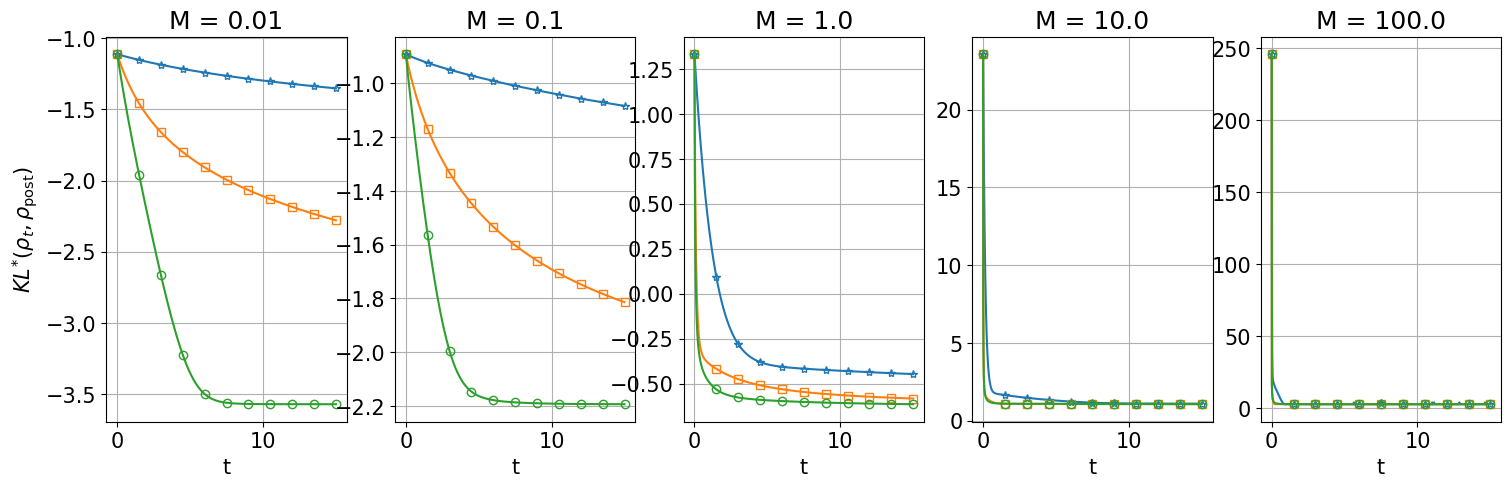

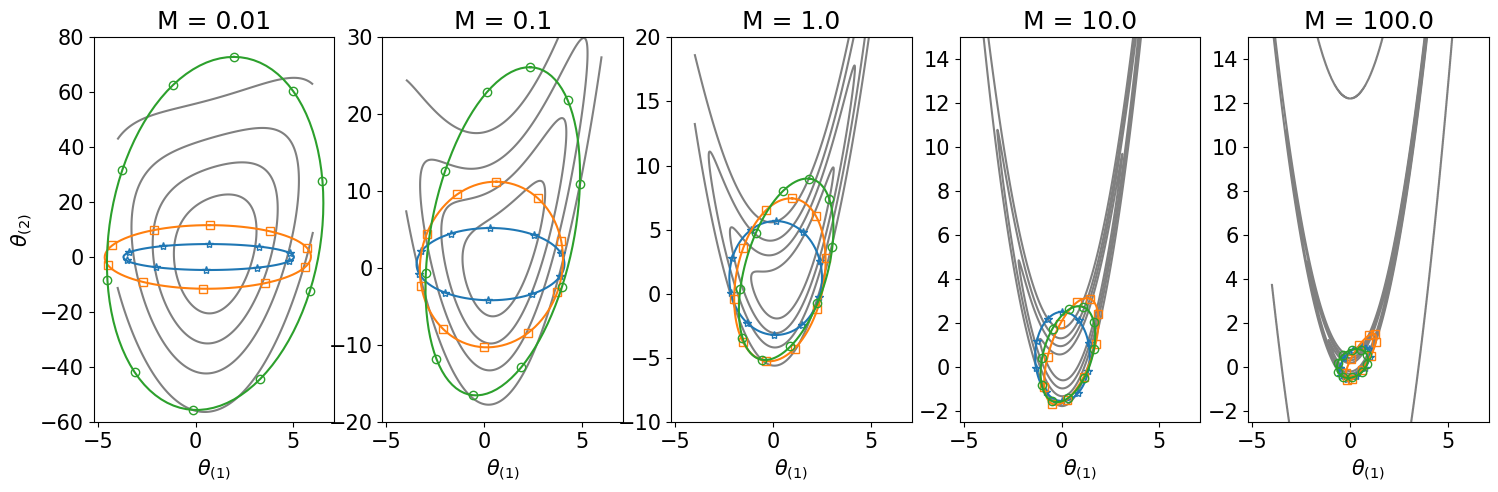

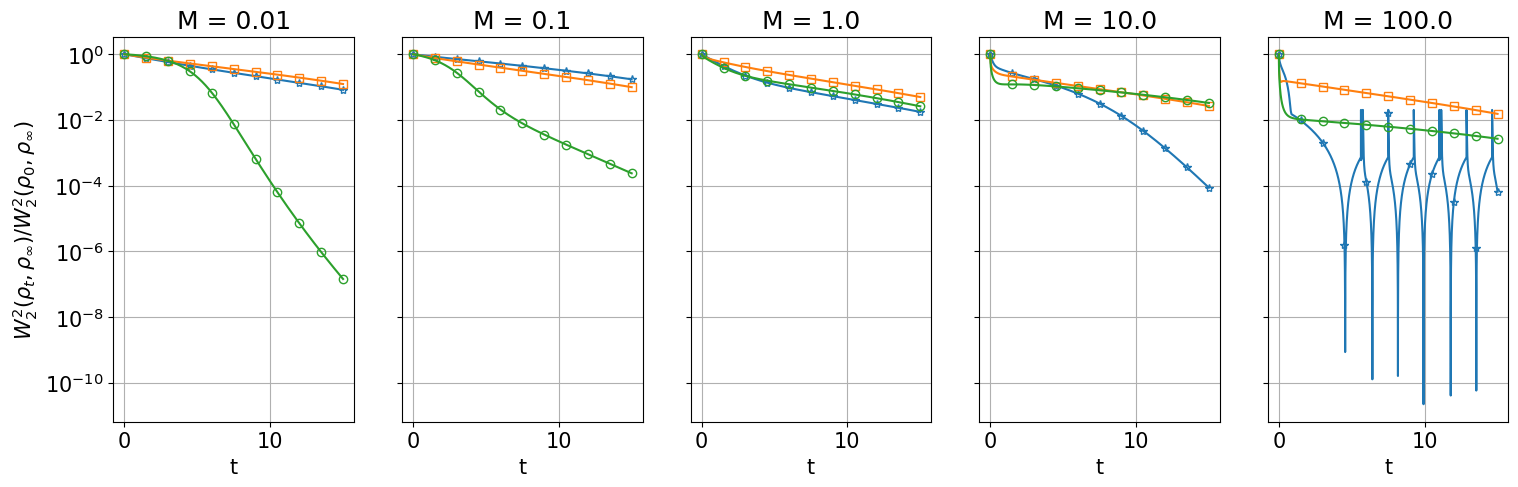

In [13]:
# ϵs = [1, sqrt(1/10), sqrt(1/100)] 
ϵs = [0.01, 0.1, 1, 10, 100] 
fig_err, ax_err = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_scatter, ax_scatter = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=false, figsize=(18,5))
fig_converge, ax_converge = PyPlot.subplots(ncols=length(ϵs), sharex=true, sharey=true, figsize=(18,5))

y_ranges = [[-60,80],[-20,30],[-10, 20],[-2.5, 15],[-2.5, 15]]

μ0, σ0 = [0.0;0.0], 2
Σ0 = [σ0^2 0.0;0.0  σ0^2]
y = [0.0; 1.0]

for test_id = 1:length(ϵs)
    

    log_ρ(θ) = log_Rosenbrock(θ,  ϵs[test_id])

    function compute_Φ(s_param, θ) 
        Φ   =  -log_ρ(θ)
        dΦ  =  -ForwardDiff.gradient(log_ρ, θ)
        ddΦ =  -ForwardDiff.hessian(log_ρ, θ)
        return Φ, dΦ, ddΦ
    end


    # compute posterior distribution by MCMC
    x_min, x_max = -4.0, 6.0
    y_min, y_max = y_ranges[test_id]
    N_x, N_y = 1000, 1000
    xx = Array(LinRange(x_min, x_max, N_x))
    yy = Array(LinRange(y_min, y_max, N_y))
    X,Y = repeat(xx, 1, N_y), repeat(yy, 1, N_x)'
    Z = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z[i, j] = log_ρ( [X[i,j], Y[i,j]] )
        end
    end
    Z .= exp.(Z)
    ax_scatter[test_id].contour(X, Y, Z, 5, colors="grey")
            
            
    N_θ = 2
    s_param = Setup_Param(N_θ, length(y)+N_θ)
    Φ_func(s_param, θ) = compute_Φ(s_param, θ) 
    sampling_method = "UnscentedTransform"
    N_ens = 1000
    Δt = 0.001
    N_iter_tot = 30000
    
    
    compute_gradient = true
    gradient_flow = "Fisher-Rao"
    ngd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Gradient_descent"
    gd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    gradient_flow = "Wasserstein"
    wgd_obj = NGD_Run(s_param, Φ_func, μ0, Σ0, sampling_method, N_ens,  Δt, N_iter_tot, compute_gradient, gradient_flow);
    @info "finish ", gradient_flow
    
    N_iter = div(N_iter_tot, 2)
    N_p=100
    X_gd,Y_gd = Gaussian_2d(gd_obj.θ_mean[N_iter], gd_obj.θθ_cov[N_iter]; std = 3, N_p=N_p)
    ax_scatter[test_id].plot(X_gd, Y_gd, "-*", fillstyle="none", markevery=div(N_p, 10), color="C0", label="Gradient descent")
    X_wgd,Y_wgd = Gaussian_2d(wgd_obj.θ_mean[N_iter], wgd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_wgd, Y_wgd, "-s", fillstyle="none", markevery=div(N_p, 10), color="C1", label="Wasserstein gradient descent")
    X_ngd,Y_ngd = Gaussian_2d(ngd_obj.θ_mean[N_iter], ngd_obj.θθ_cov[N_iter])
    ax_scatter[test_id].plot(X_ngd, Y_ngd, "-o", fillstyle="none", markevery=div(N_p, 10), color="C2", label="Natural gradient descent")
    ax_scatter[test_id].set_title("M = " * string(ϵs[test_id]))
    
    if test_id ==1
        ax_scatter[test_id].set_ylabel(L"\theta_{(2)}")
    end
    ax_scatter[test_id].set_xlabel(L"\theta_{(1)}")
#     if test_id == length(ϵs)
#         ax_scatter[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    e_gd = zeros(N_iter+1)
    e_wgd = zeros(N_iter+1)
    e_ngd = zeros(N_iter+1)
    for i = 1:N_iter+1
        e_gd[i]  = KL_estimator(gd_obj.θ_mean[i],  gd_obj.θθ_cov[i], log_Rosenbrock)  
        e_wgd[i] = KL_estimator(wgd_obj.θ_mean[i], wgd_obj.θθ_cov[i], log_Rosenbrock)  
        e_ngd[i] = KL_estimator(ngd_obj.θ_mean[i], ngd_obj.θθ_cov[i], log_Rosenbrock)  
    end
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_err[test_id].plot(ts, e_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_err[test_id].plot(ts, e_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_err[test_id].plot(ts, e_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_err[test_id].set_title("M = " * string(ϵs[test_id]))
            
    if test_id ==1
        ax_err[test_id].set_ylabel(L" KL^{*}(ρ_t , ρ_{\rm post})")
    end
    
    ax_err[test_id].set_xlabel("t")
    ax_err[test_id].grid("on")
    
#     if test_id == length(ϵs)
#         ax_err[test_id].legend(bbox_to_anchor=(1.0, 1.0))
#     end
    
    
    ekl_gd, ekl_ngd, ekl_wgd = zeros(N_iter+1),  zeros(N_iter+1),  zeros(N_iter+1)
    for i = 1:N_iter+1
        
        
        m_oo, C_oo = ngd_obj.θ_mean[end], ngd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * ngd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_ngd[i]  = ( norm(ngd_obj.θ_mean[i] - m_oo)^2 + tr(ngd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
        
        m_oo, C_oo = gd_obj.θ_mean[end], gd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * gd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_gd[i]  = ( norm(gd_obj.θ_mean[i] - m_oo)^2 + tr(gd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )


        m_oo, C_oo = wgd_obj.θ_mean[end], wgd_obj.θθ_cov[end]
        U,S,V = svd(C_oo)
        C_oo_sqrt = U*Diagonal(sqrt.(S))*V'
        U,S,V = svd(C_oo_sqrt * wgd_obj.θθ_cov[i] * C_oo_sqrt)
        ekl_wgd[i]  = ( norm(wgd_obj.θ_mean[i] - m_oo)^2 + tr(wgd_obj.θθ_cov[i] + C_oo - 2*U*Diagonal(sqrt.(S))*V') )
    end
    
    ekl_wgd ./= ekl_wgd[1]
    ekl_gd  ./= ekl_gd[1]
    ekl_ngd ./= ekl_ngd[1]
    
    ts = Array(0:N_iter) * Δt
    markevery = div(N_iter,10)
    ax_converge[test_id].semilogy(ts, ekl_gd,  "-*", fillstyle="none", markevery=div(N_iter, 10), label="Gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_wgd, "-s", fillstyle="none", markevery=div(N_iter, 10), label="Wasserstein gradient descent")
    ax_converge[test_id].semilogy(ts, ekl_ngd, "-o", fillstyle="none", markevery=div(N_iter, 10), label="Natural gradient descent")
    ax_converge[test_id].set_title("M = " * string(ϵs[test_id]))    
    if test_id ==1
        ax_converge[test_id].set_ylabel(L" W_2^2(ρ_t , ρ_{\infty}) / W_2^2(ρ_0 , ρ_{\infty})")
    end
    ax_converge[test_id].set_xlabel("t")
    ax_converge[test_id].grid("on")
    
    
end



In [14]:
handles, labels = ax_err[1].get_legend_handles_labels()
fig_err.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_err.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_err.savefig("Rosenbrock_gd_error.pdf")


handles, labels = ax_scatter[1].get_legend_handles_labels()
fig_scatter.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_scatter.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_scatter.savefig("Rosenbrock_gd_density.pdf")

handles, labels = ax_converge[1].get_legend_handles_labels()
fig_converge.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=3)
fig_converge.subplots_adjust(bottom=0.15,top=0.8,left=0.06,right=0.98,hspace=0.2)
fig_converge.savefig("Rosenbrock_gd_converge.pdf")






┌ Info: ("Wasserstein", " preconditioner ", false)
└ @ Main In[73]:78
┌ Info: ("mean = ", [0.7131227195354726, 1.1422688620191244], " ", [0, 0])
└ @ Main In[73]:79
┌ Info: ("cov = ", [7.000722967847389 -0.5542340576556571; -0.5542340576556571 35.8536008913401], " ", [10.385787993308853 24.454041739604722; 24.454041739604722 1219.1164265121283])
└ @ Main In[73]:80
┌ Info: ("Wasserstein", " preconditioner ", true)
└ @ Main In[73]:78
┌ Info: ("mean = ", [0.42270991024122284, 9.708105974819926], " ", [0, 0])
└ @ Main In[73]:79
┌ Info: ("cov = ", [7.524698071824822 15.124378142237328; 15.124378142237328 920.9434539714459], " ", [10.385787993308853 24.454041739604722; 24.454041739604722 1219.1164265121283])
└ @ Main In[73]:80
┌ Info: ("Stein", " preconditioner ", false)
└ @ Main In[73]:78
┌ Info: ("mean = ", [0.8793030866232803, 0.7351913493543212], " ", [0, 0])
└ @ Main In[73]:79
┌ Info: ("cov = ", [4.426236733698012 -0.05448624133852467; -0.05448624133852467 4.904795520648587], " ", [10.38

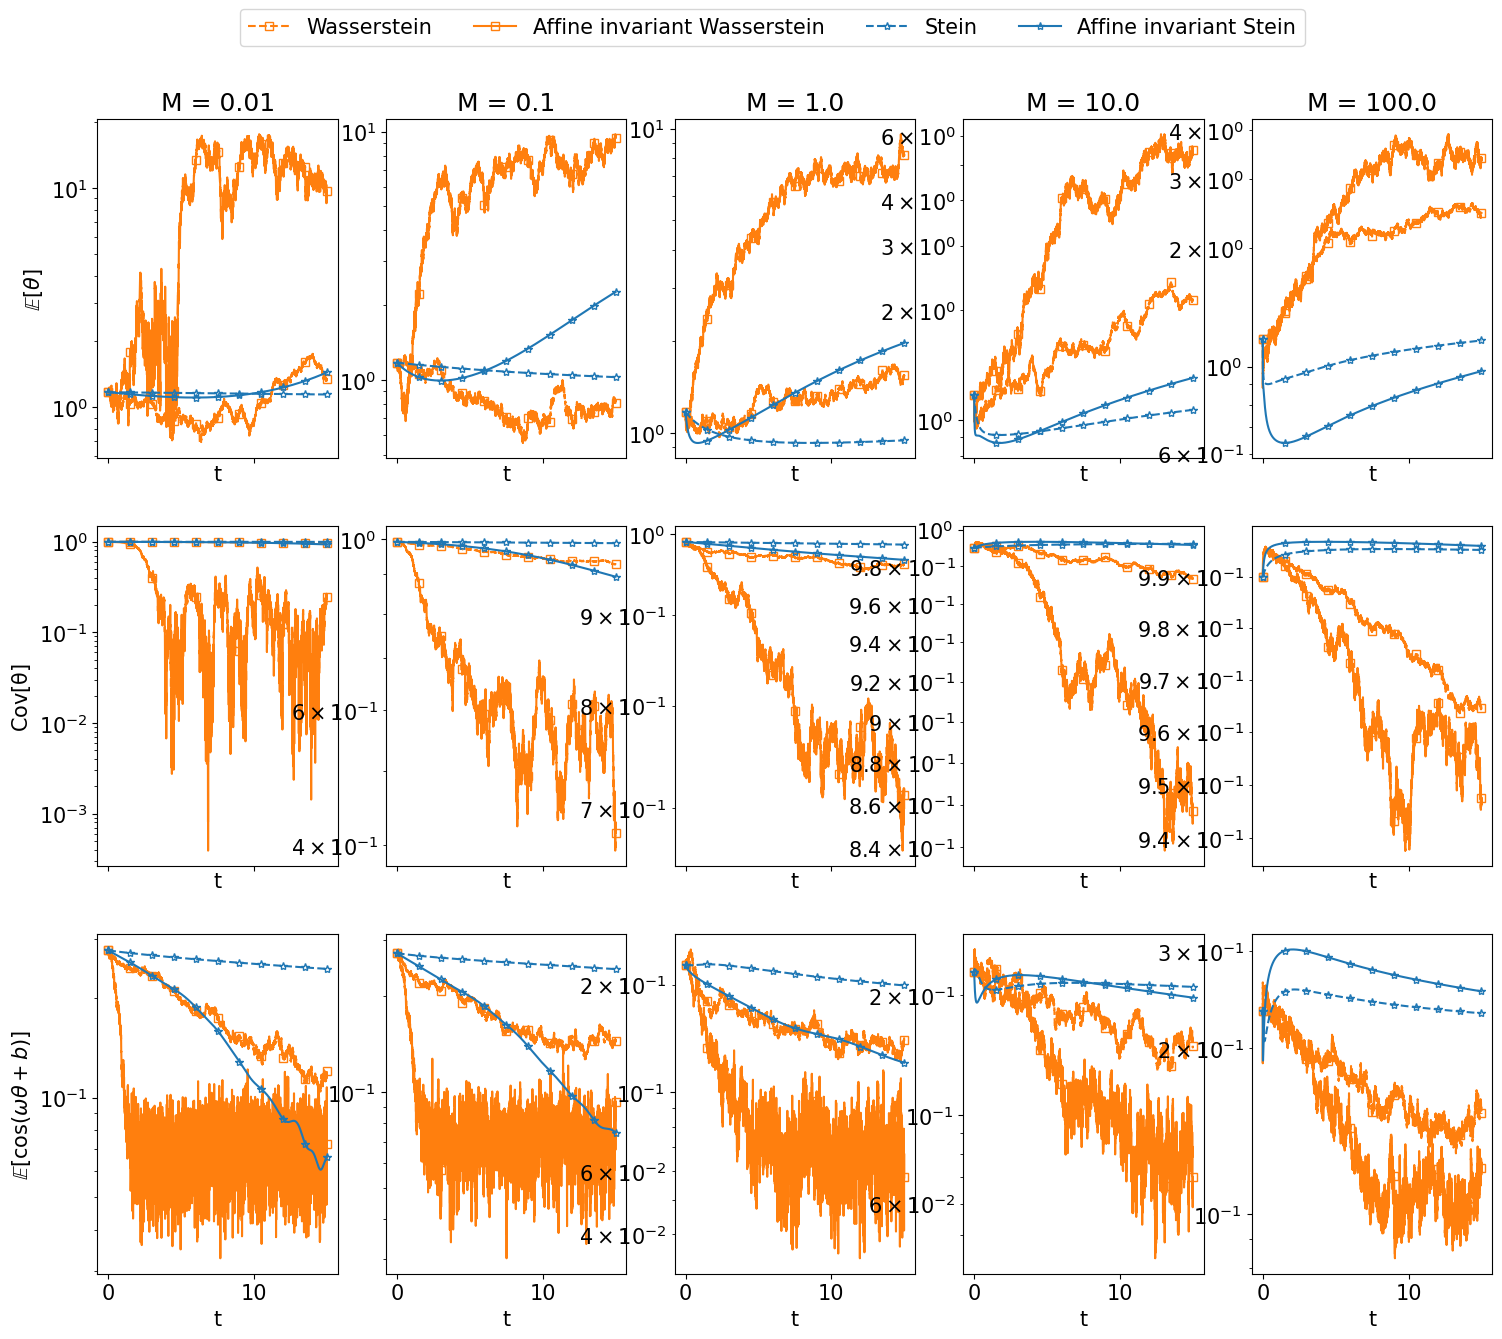

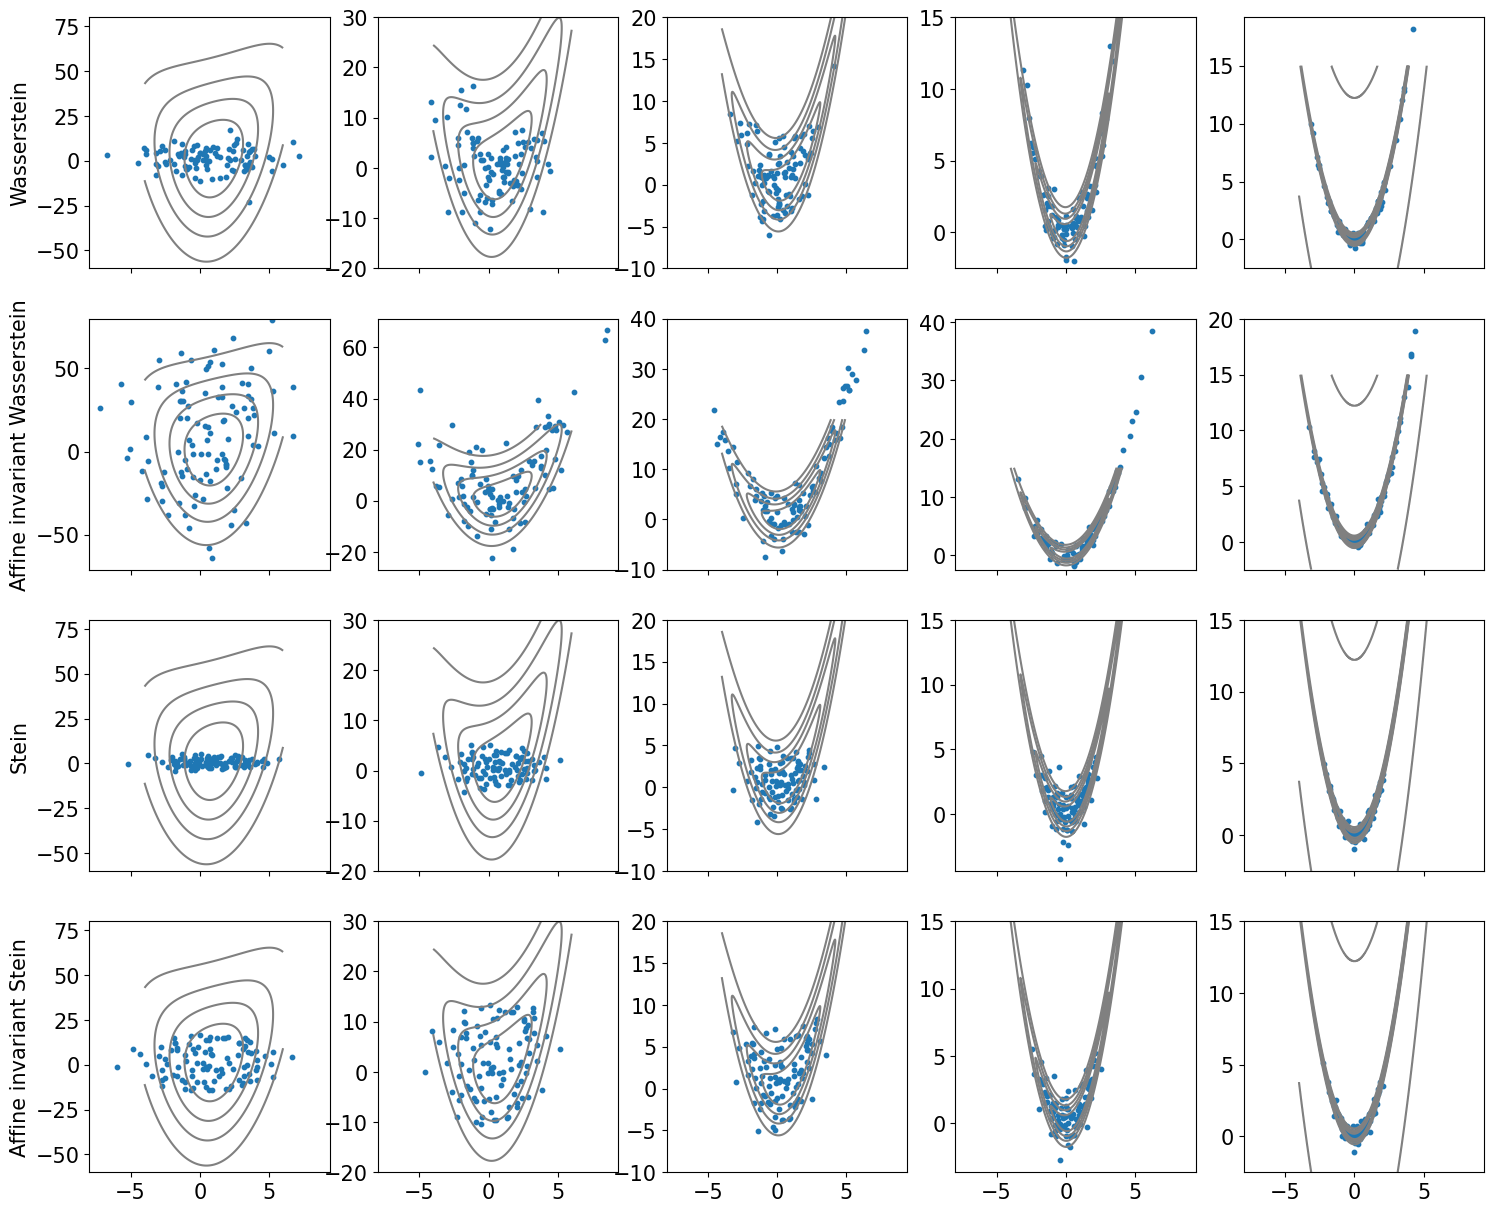

PyObject Text(29.999999999999986, 0.5, 'Affine invariant Stein')

In [73]:
include("../Inversion/IPS.jl")
include("../Inversion/Plot.jl")
include("../Inversion/Utility.jl")

Random.seed!(42)
######################### TEST #######################################
N_θ = 2
m_0 = [1.0; 1.0]
σ0 = 2
C_0 = [σ0^2  0.0; 0.0  σ0^2]
ϵs = [0.01, 0.1, 1, 10, 100] 

s_param = Setup_Param(2, 2)
fig, ax = PyPlot.subplots(ncols=5, nrows=3, sharex=true, sharey=false, figsize=(18,15))
fig_cont, ax_cont = PyPlot.subplots(ncols=5, nrows=4, sharex=true, sharey=false, figsize=(18,15))
N_ens = 100
θ0 = Array(rand(MvNormal(m_0, C_0), N_ens)')

Δt = 0.001
N_t = 15000
ts = LinRange(0, Δt*N_t, N_t+1)
xx = LinRange(-10, 10, 400)
yy = LinRange(-100, 100,  4000)
ω =  rand(Normal(0, 1), (20, 2))
b = rand(Uniform(0, 2*pi), 20)
y_ranges = [[-60,80],[-20,30],[-10, 20],[-2.5, 15],[-2.5, 15]]

for test_id = 1:length(ϵs)
    
    ϵ = ϵs[test_id]
    
    logρ(θ) = log_Rosenbrock(θ,  ϵs[test_id])
    
    function ∇logρ(s_param::Setup_Param, θ)
        return ForwardDiff.gradient(logρ, θ)
    end
    f=(θ)->θ
    m_oo = mean_estimation_2d(2, f, logρ , xx, yy)
    f=(θ)->(θ*θ')[:]
    C_oo = reshape( mean_estimation_2d(4, f, logρ , xx, yy), (2,2) ) 
    cos_ref = cos_error_estimation_particle(logρ, xx, yy, ω, b ) 
    
    
    
    # compute posterior distribution by MCMC
    x_min, x_max = -4.0, 6.0
    y_min, y_max = y_ranges[test_id]
    N_x, N_y = 1000, 1000
    xx_cont = Array(LinRange(x_min, x_max, N_x))
    yy_cont = Array(LinRange(y_min, y_max, N_y))
    X_cont,Y_cont = repeat(xx_cont, 1, N_y), repeat(yy_cont, 1, N_x)'
    Z_cont = zeros(N_x, N_y)
    for i = 1:N_x
        for j = 1:N_y
            Z_cont[i, j] = logρ( [X_cont[i,j], Y_cont[i,j]] )
        end
    end
    Z_cont .= exp.(Z_cont)
    for i = 1:4
        ax_cont[i, test_id].contour(X_cont, Y_cont, Z_cont, 5, colors="grey")
    end
         
    
    
    

    for method in ["Wasserstein", "Stein"]
        for preconditioner in [false, true]
    
            ips_obj = IPS_Run(s_param, ∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner)

            ips_errors    = zeros(N_t+1, 3)
            for i = 1:N_t+1
                ips_errors[i, 1] = norm(dropdims(mean(ips_obj.θ[i], dims=1), dims=1) .- m_oo)
                ips_errors[i, 2] = norm(construct_cov(ips_obj, ips_obj.θ[i]) .- C_oo)/norm(C_oo)
                ips_errors[i, 3] = norm(cos_ref - cos_error_estimation_particle(ips_obj.θ[i], ω, b ))/sqrt(length(b))
            end
            @info method, " preconditioner ", preconditioner
            @info "mean = ", dropdims(mean(ips_obj.θ[end], dims=1), dims=1), " ", m_oo
            @info "cov = ", construct_cov(ips_obj, ips_obj.θ[end]), " ", C_oo
            
            

            ites = Array(0:N_t)
            markevery = div(N_t, 10)
            label, color, marker = "Fisher-Rao", "C2", "o"
            if (method  == "Wasserstein" || method  == "Stein")
                label = preconditioner ? "Affine invariant "*method : method
                color = (method  == "Stein" ? "C0" : "C1")
                marker = (method  == "Stein" ? "*" : "s")
            end
            linestyle = preconditioner ?  "solid" : "dashed"
            
            
            ax[1, test_id].semilogy(ts, ips_errors[:, 1], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[2, test_id].semilogy(ts, ips_errors[:, 2], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            ax[3, test_id].semilogy(ts, ips_errors[:, 3], linestyle=linestyle, color=color, marker=marker, fillstyle="none", label=label, markevery = markevery)
            
            
            
            if (method == "Wasserstein" && ~preconditioner)
                ax_cont[1, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Wasserstein" && preconditioner)
                ax_cont[2, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            elseif (method == "Stein" && ~preconditioner)
                ax_cont[3, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            else 
                ax_cont[4, test_id].scatter(ips_obj.θ[end][:, 1], ips_obj.θ[end][:, 2], s = 10)
            end

        end
    end

                
    ax[1, test_id].set_title("M = " * string(ϵ))
    ax[1, test_id].set_xlabel("t")
    ax[2, test_id].set_xlabel("t")
    ax[3, test_id].set_xlabel("t")
end


handles, labels = ax[1,1].get_legend_handles_labels()
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.96),ncol=5)
ax[1,1].set_ylabel(L"$\mathbb{E}[\theta]$")
ax[2,1].set_ylabel(L"\rm{Cov}[\theta]")
ax[3,1].set_ylabel(L"$\mathbb{E}[\cos(\omega\theta + b)]$")

ax_cont[1, 1].set_ylabel("Wasserstein")
ax_cont[2, 1].set_ylabel("Affine invariant Wasserstein")
ax_cont[3, 1].set_ylabel("Stein")
ax_cont[4, 1].set_ylabel("Affine invariant Stein")
